# First Classification Models
#### Reid Souchereau
#### October 2020

In [1]:
# Import our data from scikitlearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


So we have 70k data points that represent various characters. As we can see by the labels, this dataset has some sort of value for each specific pixel intensity. Lets look and see what some of these actually look like.

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

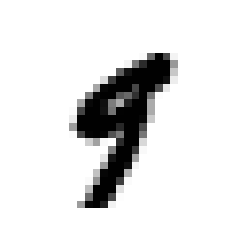

In [4]:
rand_digit = X[36000]

# Turn 28x28 pixels into actual picture
rand_digit_image = rand_digit.reshape(28,28)

plt.imshow(rand_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

'9'

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#Shuffle sets for cross-validation
import numpy as np

shuffle = np.random.permutation(60000)
X_train,y_train = X_train[shuffle], y_train[shuffle]

## Train Binary Classifier

For our first task we want to find just 9's. We're gonna start off with an SGD Classifier.

In [8]:
y_train_9 = (y_train=='9')
y_test_9 = (y_test=='9')

In [9]:
from sklearn.linear_model import SGDClassifier

In [10]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd.predict([rand_digit])

array([False])

In [12]:
y_train[36000]

'8'

So we can see that this is a working classifier now. Now we need to evaluate its overall performance. We can do a cross-validation and measure for *accuracy*

## Performance Measures

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9489 , 0.93175, 0.94125])

Roughly 94% accuracy, not bad to start. However...we have a 90% chance of it not being a five... so this actually does skew our results, and we should reanalyze our performance measures.

We can make a confusion matrix to better understand which of these classes are getting misclassified.

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_9, cv=5)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[53164,   887],
       [ 2386,  3563]], dtype=int64)

Here we only have two classes, because technically we changed our model into a binary classifier that is looking specifically for 9's.

- We had 1077 false negatives and 1680 false positives, and 4076 were properly classified

We can try to use precision as a measure for the accuracy of the positive predictions.

$precision = \frac{TP}{TP+FP}$

Alongside we can get our recall.

$recall = \frac{TP}{TP+FN}$

In [16]:
from sklearn.metrics import precision_score, recall_score

In [17]:
precision_score(y_train_9, y_train_pred)

0.8006741573033708

In [18]:
recall_score(y_train_9, y_train_pred)

0.5989241889393175

Out of the times that our model made a prediction if the character was a 9, it was right only 59% of the time. It detects 84% of the 9's.

#### F-score

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

The f-score will favor classifiers that have a similar precision and recall. We will only get a high $F_1$ score if both recall and precision are high.

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.6852581979036445

In [20]:
y_scores = sgd.decision_function([rand_digit])
y_scores

array([-3947.2150058])

In [21]:
y_scores = cross_val_predict(sgd, X_train, y_train_9, cv=3, method='decision_function')

We do have to worry about the trade off between precision and recall. We can go ahead plot a precision/recall curve to get a better understanding of a threshold value we might want to choose.

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

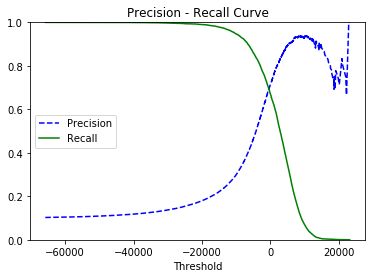

In [23]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.ylim([0,1])
plt.title("Precision - Recall Curve")
plt.show()

We would ideally like to aim for around 90% precision. However that will come at the cost of a slight trade off in recall as 90% precision would correspond with roughly a 5000 threshold, and lower our recall all the way to around 40%. Lets figure out if we can optimize this a bit.

In [24]:
# Maximize f-score
x_thresh = np.linspace(-5000,5000,1000)
max_score = 0
max_val = 0
for val in x_thresh:
    f_score = f1_score(y_train_9, (y_scores > val))
    if f_score > max_score:
        max_score = f_score
        max_val = val
print("maximum f1 score: {0}\nthreshold of max f1 score:{1}".format(max_score,max_val))

maximum f1 score: 0.694078947368421
threshold of max f1 score:-745.7457457457458


In [25]:
precision_score(y_train_9, (y_scores>635))

0.7420929324482624

This optimization is not exactly what we want. Lets try a higher threshold to reach better precision.

In [26]:
precision_score(y_train_9, (y_scores>7000))

0.927437641723356

This should be sufficient for now.

#### ROC Curve

The reciever operating characteristic will plot our true positive rate against the false positive rate.

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

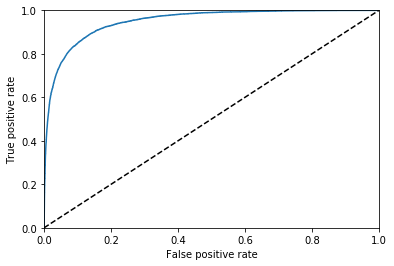

In [28]:
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

Lets get an actual metric so we can compare this quantitatively describe our roc values. We can us ROC area under curve to quantify this.

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9491547020431532

Lets see if we can improve this with another model. Lets try a random forest classifier first.

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest, X_train, y_train_9, cv=3, method="predict_proba")

In [31]:
y_scores_forest = y_probs_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

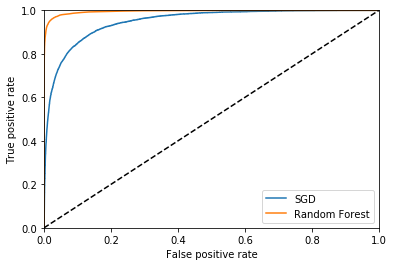

In [32]:
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0,1], [0,1],'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

In [33]:
roc_auc_score(y_train_9, y_scores_forest)

0.9951904124068974

This is pretty good! This significantly improves our ROC AUC score by switching to a random forest classifier.

## Multiclass Classification

### Retrain SGD as Multiclass Classifier

ScikitLearn will automatically attempt to use one versus all strategy for creating a multiclass classifier with a binary classifier algorithm. So, if we are to use a stochastic gradient descent algorithm on our dataset as a multiclass classifier, it will automatically run.

In [34]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
sgd.predict([rand_digit])

array(['3'], dtype='<U1')

It is working now as a multiclass classifier.

In [36]:
rand_digit_scores = sgd.decision_function([rand_digit])

So as we can see from the decision function scores, there is actually 10 separate classifier scores. The highest score is for 4, and that is why we get it returned as our prediction.

In [37]:
np.argmax(rand_digit_scores)

3

In [38]:
sgd.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [39]:
sgd.classes_[4]

'4'

If we want ScikitLearn to utilize a One versus One strategy for the binary classifiers as multiclass classifiers, we can just utilize the *OneVsOneClassifier* or *OneVsRestClassifer* classes.

In [40]:
from sklearn.multiclass import OneVsOneClassifier
ovo = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [41]:
ovo.predict([rand_digit])

array(['9'], dtype=object)

So we can see that now we have a one vs one classifier that also works.

In [42]:
ovo.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [43]:
len(ovo.estimators_)

45

### Random Forest Classifier Multiclass

In [44]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
forest.predict([rand_digit])

array(['9'], dtype=object)

This random forest classifier is working now. Rather than a decision function, it utilizes probability of each digit to predict the most likely class.

In [46]:
forest.predict_proba([rand_digit])

array([[0.  , 0.  , 0.  , 0.  , 0.07, 0.01, 0.01, 0.  , 0.  , 0.91]])

So the highest probability is given as 9 for this class.

## Error and Evaluation

Ok. We have working algorithms, which is great, but we haven't actually looked at their accuracy or effectiveness.

In [47]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([0.86525, 0.8741 , 0.88655])

So from the cross validation score we have fairly high accuracy. Another way we can improve our accuracy is by scaling our inputs.

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [49]:
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\Reid\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.8998 , 0.90085, 0.90475])

This slightly increased our average accuracy a couple of percentage points.

### Confusion Matrix

In [50]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train,cv=3)
confusionmat = confusion_matrix(y_train, y_train_pred)

C:\Users\Reid\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [51]:
confusionmat

array([[5601,    0,   17,    9,    9,   44,   35,    6,  201,    1],
       [   0, 6409,   47,   20,    3,   44,    4,   10,  192,   13],
       [  31,   27, 5271,   83,   72,   21,   65,   41,  338,    9],
       [  28,   21,  125, 5248,    0,  206,   25,   47,  364,   67],
       [  11,   14,   44,   11, 5239,   10,   38,   20,  298,  157],
       [  31,   16,   29,  158,   57, 4481,   76,   16,  496,   61],
       [  31,   17,   45,    2,   40,   86, 5567,    4,  126,    0],
       [  20,   12,   56,   23,   47,   11,    5, 5718,  170,  203],
       [  20,   63,   42,   94,    1,  125,   28,    9, 5426,   43],
       [  25,   24,   31,   63,  126,   36,    1,  176,  319, 5148]],
      dtype=int64)

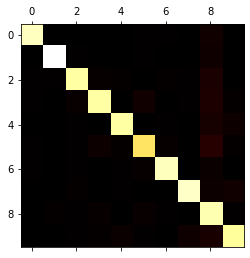

In [52]:
plt.matshow(confusionmat, cmap=plt.cm.afmhot)
plt.show()

This confusion matrix actually looks pretty good, since most images are on the main diagonal. For us, it seems that the 8 has some light color to it, meaning it has some wrongly classified classes. This could be because there were just more instances of 8's, rather that the actual error rate. So let's get the relative error rather than absolute error.

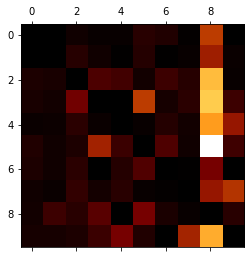

In [53]:
row_sums = confusionmat.sum(axis=1, keepdims=True)
norm_conf_mat = confusionmat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.afmhot)
plt.show()

We can now confirm that 8's are being misclassified much more frequently than any other class. A few other outliers include 3-5 misclassification and 7-9.

## Multilabel Classification

In [54]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

TypeError: not all arguments converted during string formatting

## Titanic Classification

In [55]:
import pandas as pd
t_train = pd.read_csv("datasets/titanic/train.csv")
t_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
t_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [57]:
t_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [58]:
t_train.groupby(by="Sex").sum()["Survived"]/t_train["Sex"].value_counts()

female    0.742038
male      0.188908
dtype: float64

In [59]:
yt = t_train.pop("Survived").values

In [60]:
t_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [61]:
t_train["Cabin"].value_counts(dropna=False)

NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
F33              3
              ... 
E10              1
E36              1
D6               1
C70              1
A7               1
Name: Cabin, Length: 148, dtype: int64

In [62]:
t_train.shape[0]

891

### Build Pipeline for Titanic Dataset

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

Here is our plan:
First, we need to drop *Cabin* because it is missing so many values. *Embarked* needs to be imputed because it is missing some values, then encoded with OneHotEncoder. *Sex* needs to be encoded. Then the rest of the numerical columns need to be scaled

#### Name Pipeline

Create custom transformer to modify the name. It will extract prefixes as a classification.

In [114]:
class extract_prefixes(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kwargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X["Name"].str.split(", ").str.get(1).str.split(" ").str.get(0).str.replace(".","").values.reshape(-1,1)

In [115]:
# Create pipeline to strip names into just prefixes
name_pipeline = Pipeline([
    ("Extract Prefix", extract_prefixes()),
    ("Encoder", OneHotEncoder(sparse=False))
])

#### Num Pipeline

Numerical pipeline for processing numerical columns.

In [136]:
num_pipeline = Pipeline([
    ("Simple Imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
    ("Standard Scaler", StandardScaler())
    ])

#### Categorical Pipeline
This will be for *Sex* and *Embarked*

In [127]:
cat_pipeline = Pipeline([
    ("Simple Imputer", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
    ("Encoder", OneHotEncoder()),
])

In [137]:
# Define numerical columns for transformer
numeric_col_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_col_names = t_train.select_dtypes(numeric_col_dtypes).columns

# ColumnTransformer for training data
ct = ColumnTransformer([
    ('Name Pipeline', name_pipeline, ['Name'] ),
    ('Numerical Pipeline', num_pipeline, numeric_col_names),
    ('Categorical Pipeline', cat_pipeline, ['Sex','Embarked']),
    ],
    remainder="drop"
)

train_transformed = ct.fit_transform(t_train)
train_transformed[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.73010796,  0.82737724, -0.5924806 ,
        0.43279337, -0.47367361, -0.50244517,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

### Model Selection

For the titantic dataset. We can start by trying a stochastic gradient descent classifer as a binary classification for survival.

#### SGD Classifier

In [139]:
titanic_sgd = SGDClassifier(random_state=1).fit(train_transformed,yt)

In [152]:
y_train_pred = cross_val_score(titanic_sgd, train_transformed, yt, cv=5)
y_train_pred.mean()

0.7912748728893353

#### Random Forest Classifier

In [153]:
titanic_forest = RandomForestClassifier(random_state=1)

In [154]:
y_train_pred_forest = cross_val_score(titanic_forest, train_transformed, yt, cv=5)

In [155]:
y_train_pred_forest.mean()

0.8103759964848409

#### Multilayer Perceptitron Classifier

In [156]:
from sklearn.neural_network import MLPClassifier

In [157]:
titanic_mlp = MLPClassifier(random_state=1)

In [159]:
y_train_pred_mlp = cross_val_score(titanic_mlp, train_transformed, yt, cv=5)
y_train_pred_mlp

C:\Users\Reid\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Reid\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Reid\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Reid\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

array([0.82122905, 0.78651685, 0.84831461, 0.80337079, 0.83707865])

In [160]:
y_train_pred_mlp.mean()

0.8193019898311468

### Fine Tune Model

I am going to go with our MLP Classifier in attempt to raise its power. We can start with a grid search to try and tune its hyperparameters.

In [161]:
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}

grid_search = GridSearchCV(titanic_mlp, parameters, n_jobs=-1)

In [162]:
grid_search.fit(train_transformed, yt)
print(grid_search.score(train_transformed, yt))

0.8900112233445566


C:\Users\Reid\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


89% accuracy! A decent bit better than our previous models. Let's see our paramaters and then test this on our test sample.

In [164]:
grid_search.best_params_

{'alpha': 1e-07,
 'hidden_layer_sizes': 10,
 'max_iter': 1000,
 'random_state': 7,
 'solver': 'lbfgs'}

In [165]:
grid_search.best_estimator_

MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=7, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [166]:
final_mdl = grid_search.best_estimator_